In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import OrderedDict
import plotly.graph_objects as go

from trainer import Trainer

# Generate data

In [2]:
X = torch.linspace(-torch.pi, torch.pi, 100)
Y = torch.sin(X) + torch.normal(mean=0, std=torch.full(X.shape, 0.05))
tr_data = torch.stack([X, Y], dim=1)

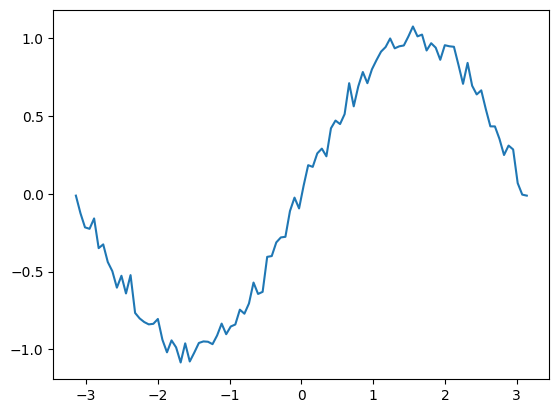

In [3]:
plt.plot(X, Y)
plt.show()

# Model

In [4]:
class SimpleModel(nn.Module):
    """
    Simple model for testing
    """
    def __init__(self, output_dim: int):
        super().__init__()
        self.net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                                 nn.LazyLinear(4), nn.ReLU(),
                                 )
        self.last_proj = nn.LazyLinear(output_dim)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.last_proj(self.net(X))

    def loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        loss_fn = nn.MSELoss()
        return loss_fn(y_hat, y)

In [5]:
model=SimpleModel(output_dim=1)

/Users/dmitripedchenko/miniconda3/envs/loss_func/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


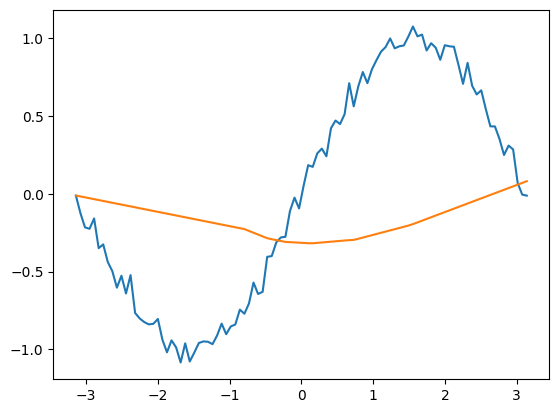

In [6]:
plt.plot(X,Y)
plt.plot(X, model(X.reshape(-1, 1)).detach())

Train

In [7]:
class Trainer:
    def __init__(
        self,
        train_epochs: int,
        lr: float = 0.02,
        optimizer: torch.optim.Optimizer = torch.optim.SGD,
    ):
        self.train_epochs = train_epochs
        self.lr = lr
        self.optimizer = optimizer

    def train(self, model, tr_data: torch.Tensor, print_epoch: int = 100):
        self.tr_data = tr_data
        self.model = model
        self.model_optimizer = self.optimizer(self.model.parameters(), lr=self.lr)
        self.model.train()
        for epoch in range(self.train_epochs):
            if epoch % print_epoch == 0:
                print("Training epoch", epoch)
            self.fit_epoch()

    def fit_epoch(self):
        # TODO Train with batches after dataloader is implemented
        loss = self.model.loss(
            self.model(self.tr_data[:, :-1]).squeeze(), self.tr_data[:, -1]
        )
        self.model_optimizer.zero_grad()
        with torch.no_grad():
            loss.backward()
            self.model_optimizer.step()

In [8]:
trainer = Trainer(train_epochs=10_000, lr = 0.1)

In [9]:
trainer.train(model, tr_data, print_epoch=1_000)

Training epoch 0
Training epoch 1000
Training epoch 2000
Training epoch 3000
Training epoch 4000
Training epoch 5000
Training epoch 6000
Training epoch 7000
Training epoch 8000
Training epoch 9000


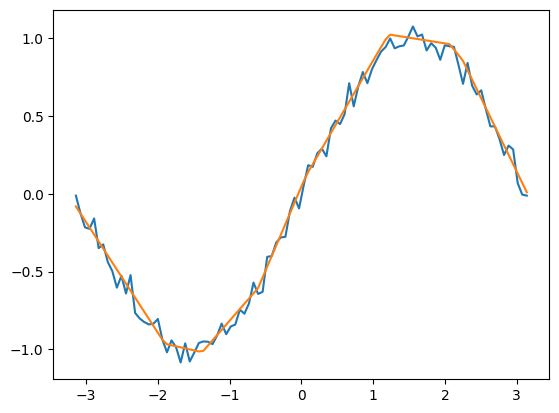

In [10]:
plt.plot(X,Y)
plt.plot(X, model(X.reshape(-1, 1)).detach())
plt.show()

# Plot of loss function as the function of model parameters

## Plot function along a direction vector in param space

In [11]:
model.eval()
trained_weights = model.state_dict()
trained_weights

OrderedDict([('net.0.weight',
              tensor([[-0.2083],
                      [ 0.2799],
                      [-0.1455],
                      [ 1.2472],
                      [ 0.4731],
                      [ 0.0289],
                      [-1.1413],
                      [-0.0552]])),
             ('net.0.bias',
              tensor([-0.9728, -0.2899, -0.7153, -1.5155,  0.8985, -0.6189,  0.0746, -0.9890])),
             ('net.2.weight',
              tensor([[ 0.0702,  0.2025, -0.0752,  0.6706,  0.0424,  0.1831, -0.0617,  0.0330],
                      [-0.1439, -0.0965, -0.3409, -0.0297,  0.1564,  0.1705, -0.6510,  0.1875],
                      [ 0.2460, -0.2041,  0.0804, -0.6173,  0.4029,  0.3203, -0.6144, -0.3277],
                      [-0.3206, -0.1166,  0.0050,  0.1587, -0.9050,  0.2360, -0.4398,  0.3513]])),
             ('net.2.bias', tensor([-0.8517,  0.4009,  0.9165,  1.6115])),
             ('last_proj.weight',
              tensor([[-0.5529,  0.6752,  0.7104, -1

Randomly init direction vector

In [12]:
dir_vec = OrderedDict(
    (name, torch.normal(mean=0, std=torch.full(t.shape, 0.01)))
    for name, t in trained_weights.items()
)
dir_vec

OrderedDict([('net.0.weight',
              tensor([[ 0.0024],
                      [-0.0059],
                      [ 0.0175],
                      [-0.0030],
                      [-0.0053],
                      [ 0.0032],
                      [ 0.0055],
                      [-0.0065]])),
             ('net.0.bias',
              tensor([-0.0181, -0.0029,  0.0038,  0.0057,  0.0183, -0.0043,  0.0104,  0.0078])),
             ('net.2.weight',
              tensor([[-0.0063,  0.0114, -0.0008, -0.0108, -0.0099,  0.0147,  0.0021,  0.0023],
                      [ 0.0072,  0.0078, -0.0012,  0.0015,  0.0194, -0.0084,  0.0089, -0.0093],
                      [-0.0056, -0.0040, -0.0022,  0.0084,  0.0052, -0.0008, -0.0041,  0.0032],
                      [-0.0008, -0.0005,  0.0029, -0.0033,  0.0124, -0.0155,  0.0077, -0.0056]])),
             ('net.2.bias', tensor([-0.0118,  0.0054,  0.0100,  0.0004])),
             ('last_proj.weight',
              tensor([[ 0.0093,  0.0049,  0.0078, -0

In [13]:
line_param =  torch.linspace(-1, 1, steps=100)
losses = []
for param in line_param:
    scaled_dir_vec = OrderedDict(
        (name, param * t) for name, t in dir_vec.items()
    )
    model.load_state_dict(scaled_dir_vec)
    losses.append(model.loss(model(tr_data[:, :-1]).squeeze(), Y).detach())

Good, we are near a minimum in this direction, and the function is nice and convex.

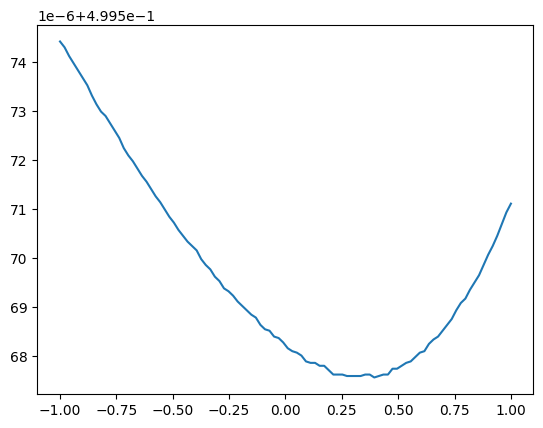

In [14]:
plt.plot(line_param, losses)
plt.show()

## Plot along a direction plane

In [15]:
dir_vec1 = OrderedDict(
    (name, torch.normal(mean=0, std=torch.full(t.shape, 0.01)))
    for name, t in trained_weights.items()
)
dir_vec2 = OrderedDict(
    (name, torch.normal(mean=0, std=torch.full(t.shape, 0.01)))
    for name, t in trained_weights.items()
)

In [16]:
x_param = torch.linspace(-1, 1, steps=100)
y_param = torch.linspace(-1, 1, steps=100)
grid_x, grid_y = torch.meshgrid(x_param, y_param)

/Users/dmitripedchenko/miniconda3/envs/loss_func/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
grid_x

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9798, -0.9798, -0.9798,  ..., -0.9798, -0.9798, -0.9798],
        [-0.9596, -0.9596, -0.9596,  ..., -0.9596, -0.9596, -0.9596],
        ...,
        [ 0.9596,  0.9596,  0.9596,  ...,  0.9596,  0.9596,  0.9596],
        [ 0.9798,  0.9798,  0.9798,  ...,  0.9798,  0.9798,  0.9798],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])

In [18]:
losses_3d = []
for x in x_param:
    for y in y_param: 
        z = OrderedDict(
            (name, x* dir_vec1[name] + y* dir_vec2[name]) 
            for  name in trained_weights.keys()
            )
        model.load_state_dict(z)
        losses_3d.append(model.loss(model(tr_data[:, :-1]).squeeze(), Y).detach())

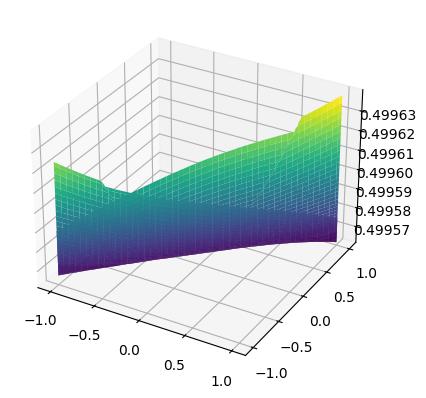

In [20]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(x_param, y_param, torch.tensor(losses_3d).reshape(100, 100), cmap="viridis")
plt.show()

In [29]:
fig = go.Figure(go.Surface(x=x_param, y=y_param, z=torch.tensor(losses_3d).reshape(100, 100)))
fig.update_layout(width=1_200, height=600)
fig.show()